In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
from matplotlib import rc
plt.style.use('classic')
rc('font', family='serif')
rc('figure', facecolor='w')
from mpl_toolkits.mplot3d import Axes3D
from astropy.io import fits, ascii
from astropy.table import Table
import astropy.units as u
import astropy.coordinates as coord
from collections import OrderedDict
from scipy.interpolate import UnivariateSpline
import os, math
from natsort import natsorted as nsort

import TheCannon
from TheCannon import apogee, dataset, model
import apogee_tools as ap
AP_PATH = os.environ['APOGEE_DATA']

line_list = ap.lines
line_names = line_list.keys()

/home/jess/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### Read in training/test data

In [2]:
allstar = fits.open('/home/jess/Desktop/Research/data/apogee_data/allStar-l31c.2.fits')
all_id = allstar[1].data['APOGEE_ID']

gaia_xmatch = fits.open('/home/jess/Desktop/Research/surveys/xmatch/apogee_x_gaiadr2_full_info.fits')
gaia_id = gaia_xmatch[1].data['APOGEE_ID_1']

len(all_id), len(gaia_id)

(277371, 254478)

In [5]:
fparam = np.array(list(gaia_xmatch[1].data['FPARAM']))
ap_teff = fparam.T[0]
ap_fe_h = fparam.T[3]
gaia_id = np.array(list(gaia_xmatch[1].data['APOGEE_ID_1']))
bp = np.array(list(gaia_xmatch[1].data['phot_bp_mean_mag']))
rp = np.array(list(gaia_xmatch[1].data['phot_rp_mean_mag']))
g  = np.array(list(gaia_xmatch[1].data['phot_g_mean_mag']))
plx = np.array(list(gaia_xmatch[1].data['parallax']))
plx_err = np.array(list(gaia_xmatch[1].data['parallax_error']))
glon = gaia_xmatch[1].data['GLON']
glat = gaia_xmatch[1].data['GLAT']
ra = gaia_xmatch[1].data['RA_1']
dec = gaia_xmatch[1].data['DEC_1']

#remove non-float items
null1 = set(np.where(np.isfinite(bp) == False)[0]) | set(np.where(np.isfinite(rp) == False)[0]) | \
        set(np.where(np.isfinite(g) == False)[0]) | set(np.where(np.isfinite(plx) == False)[0])
ind1 = np.array(list(set(np.arange(len(bp))) - null1))

gaia_id = np.array(gaia_id[ind1], dtype=str)
ap_teff = np.array(ap_teff[ind1], dtype=float)
ap_fe_h = np.array(ap_fe_h[ind1], dtype=float)
bp = np.array(bp[ind1], dtype=float)
rp = np.array(rp[ind1], dtype=float)
g = np.array(g[ind1], dtype=float)
plx = np.array(plx[ind1], dtype=float)
plx_err = np.array(plx_err[ind1], dtype=float)
glon = glon[ind1]
glat = glat[ind1]
ra = ra[ind1]
dec = dec[ind1]

#remove negative parallaxes
good_plx = np.where(plx >= 0)[0]

bp_rp = bp[good_plx] - rp[good_plx]
g_abs = g[good_plx] + 5*np.log10(plx[good_plx])-10

gaia_id = gaia_id[good_plx]
ap_teff = ap_teff[good_plx]
ap_fe_h = ap_fe_h[good_plx]
plx = plx[good_plx]
plx_err = plx_err[good_plx]
glon = glon[good_plx]
glat = glat[good_plx]
ra = ra[good_plx]
dec = dec[good_plx]

len(bp_rp), len(ap_teff), len(plx)

(240358, 240358, 240358)

In [12]:
test_files = os.listdir('/home/jess/Desktop/Research/data/apogee_data/test_sets/gaia_mdwarfs')
test_ids = [x.split('aspcapStar-r8-l31c.2-')[1].split('.fits')[0] for x in test_files]

#get the index of each test id in the all star file
id_ind = [np.where(gaia_id == tst)[0][0] for tst in test_ids]

#get gaia parameters for each test source ID
gaia_id = gaia_id[id_ind]
ap_teff = ap_teff[id_ind]
ap_fe_h = ap_fe_h[id_ind]
plx = plx[id_ind]
plx_err = plx_err[id_ind]
bp_rp = bp_rp[id_ind]
g_abs = g_abs[id_ind]
glon = glon[id_ind]
glat = glat[id_ind]
ra = ra[id_ind]
dec = dec[id_ind]

dist = 1/plx

len(test_ids), len(gaia_id), len(g_abs)

(14827, 14827, 14827)

In [8]:
west_xm = pd.read_csv('/home/jess/Desktop/Research/Mdwarf_project/cannon_runs/raw_data_files/west_x_APOGEE_x_Gaia.csv')
results_w = pd.read_csv('/home/jess/Desktop/Research/Mdwarf_project/cannon_runs/train_west/results/test_results.csv')
no_spec = list(set(west_xm['APOGEE_ID']) - set(results_w['ID']))
for miss_id in no_spec:
    west_xm = west_xm[west_xm['APOGEE_ID'] != miss_id]
ind_w = np.array([np.where(results_w['ID'] == ID)[0][0] for ID in west_xm['APOGEE_ID']])

spt = west_xm['SpT']
bp_rp_w = west_xm['phot_bp_mean_mag'] - west_xm['phot_rp_mean_mag']
g_abs_w = west_xm['phot_g_mean_mag'] + 5*np.log10(west_xm['parallax'])-10

In [9]:
dfile = AP_PATH + '/training_sets/west_sample_cut/'
rfile = '../train_ref/west_ref_labels.csv'  

ids, wl, tr_flux, tr_ivar = apogee.load_spectra(dfile)
tr_ID = np.array([x.split('2-')[1].split('.fits')[0] for x in ids])
tr_label = ap.loadLabels(rfile, lbl_names=['SPT'])
# tr_label = ap.scaleLabels(ap.loadLabels(rfile, lbl_names=['TEFF', 'FE_H']))

wave = ap.rvShift(wl, rv=-80)
trn_ds = dataset.Dataset(wave, tr_ID, tr_flux, tr_ivar, tr_label, tr_ID, tr_flux, tr_ivar)
trn_ds.set_label_names(['SPT'])

md, trn_ds, synth = ap.fitCannonModel(trn_ds)

This is the right version
Loading spectra from directory /home/jess/Desktop/Research/data/apogee_data/training_sets/west_sample_cut/
Spectra loaded
Done training model. 
Inferring Labels


### Run model on all test sources

In [10]:
def load_spectra(test_ID, **kwargs):

    data_dir = kwargs.get('dir', os.environ['APOGEE_DATA'] + '/aspcap_data')
    files = [data_dir+'/aspcapStar-r8-l31c.2-'+ID+'.fits' for ID in test_ID]
    
    nstars = len(files)    
    print('Loading', nstars, 'files...')
    
    for jj, fits_file in enumerate(files):
        if not os.path.isfile(fits_file):
            ap.download(test_ids[jj], type='aspcap', dir=data_dir)     
        try:
            file_in = fits.open(fits_file)
            flux = np.array(file_in[1].data)
            if jj == 0:
                npixels = len(flux)
                fluxes = np.zeros((nstars, npixels), dtype=float)
                ivars = np.zeros(fluxes.shape, dtype=float)
                start_wl = file_in[1].header['CRVAL1']
                diff_wl = file_in[1].header['CDELT1']
                val = diff_wl * (npixels) + start_wl
                wl_full_log = np.arange(start_wl,val, diff_wl)
                wl_full = [10 ** aval for aval in wl_full_log]
                wl = np.array(wl_full)
            flux_err = np.array((file_in[2].data))
            badpix = apogee.get_pixmask(flux, flux_err)
            ivar = np.zeros(npixels)
            ivar[~badpix] = 1. / flux_err[~badpix]**2
            fluxes[jj,:] = flux
            ivars[jj,:] = ivar
        except:
            print('Could not load file', fits_file)

    return wl, fluxes, ivars

def chi_sq(data, model, ivar):
    chi = []
    for i in range(len(data)):
        chi.append(np.sum(ivar[i]*(data[i]-model[i])**2))
    return np.array(chi)

def testCannonModel(md, test_ID, tst_dir):
        
    wl, data_flux, data_ivar = load_spectra(test_ID, dir=tst_dir)  
    print(len(test_ID), 'loaded spectra')

    wave = ap.rvShift(wl, rv=-80)
    tst_ds = dataset.Dataset(wave, test_ID, data_flux, data_ivar, None, test_ID, data_flux, data_ivar)
    tst_ds.set_label_names(trn_ds._label_names)   
    print('loaded dataset')
    
    label_errs = md.infer_labels(tst_ds)
    test_labels = tst_ds.test_label_vals
    
    test_flux = ap.labelToSpec(test_labels, md.coeffs)
    print('computed fluxes')
    
    chi = chi_sq(data_flux, test_flux, data_ivar)
    print('computed gof')
    
    return test_labels, test_flux, chi

In [13]:
tst_dir = '/home/jess/Desktop/Research/data/apogee_data/test_sets/gaia_mdwarfs'
tst_label, tst_flux, chi = testCannonModel(md, test_ids, tst_dir)

Loading 14827 files...
14827 loaded spectra
loaded dataset
Inferring Labels
computed fluxes
computed gof


### Result Diagnostic Plots

14827


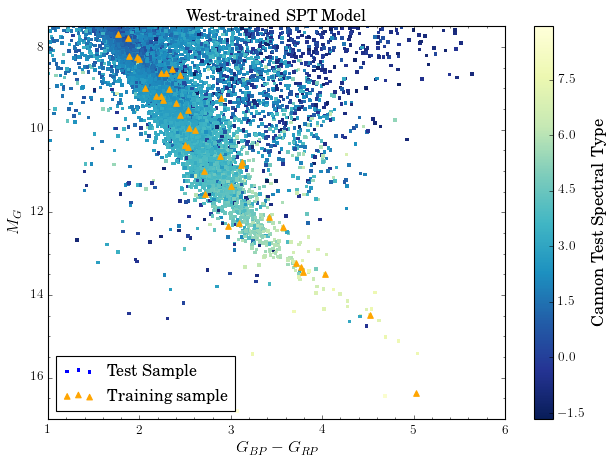

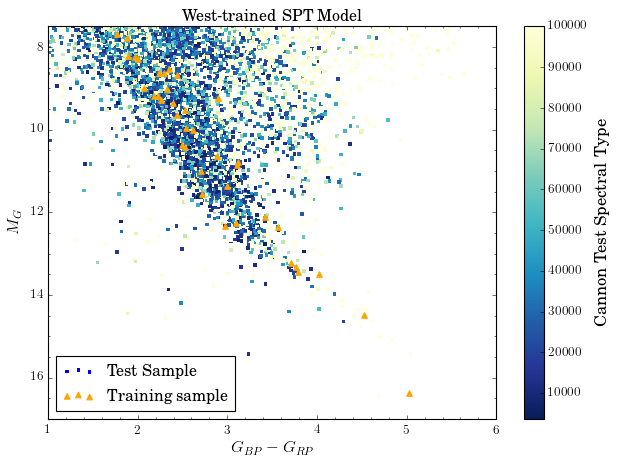

In [23]:
print(len(bp_rp))

pl = plt.scatter(bp_rp, g_abs, c=tst_label.T[0], cmap='YlGnBu_r', edgecolor='none', s=10, marker='s', \
                 label='Test Sample')
plt.scatter(bp_rp_w, g_abs_w, color='orange', marker='^', label='Training sample', s=25)
cb = plt.colorbar(pl)
cb.set_label(r'Cannon Test Spectral Type', fontsize=15)
plt.xlabel(r'$G_{BP} - G_{RP}$', fontsize=15)
plt.ylabel(r'$M_{G}$', fontsize=15)
plt.ylim(17,7.5)
plt.xlim(1,6)
plt.title('West-trained SPT Model')
plt.legend(loc='lower left')
plt.minorticks_on()
plt.tight_layout()
plt.show()

#=============

pl = plt.scatter(bp_rp, g_abs, c=np.clip(chi,0,100000), cmap='YlGnBu_r', edgecolor='none', s=10, marker='s', \
                 label='Test Sample')
plt.scatter(bp_rp_w, g_abs_w, color='orange', marker='^', label='Training sample', s=25)
cb = plt.colorbar(pl)
cb.set_label(r'Cannon Test Spectral Type', fontsize=15)
plt.xlabel(r'$G_{BP} - G_{RP}$', fontsize=15)
plt.ylabel(r'$M_{G}$', fontsize=15)
plt.ylim(17,7.5)
plt.xlim(1,6)
plt.title('West-trained SPT Model')
plt.legend(loc='lower left')
plt.minorticks_on()
plt.tight_layout()
plt.show()

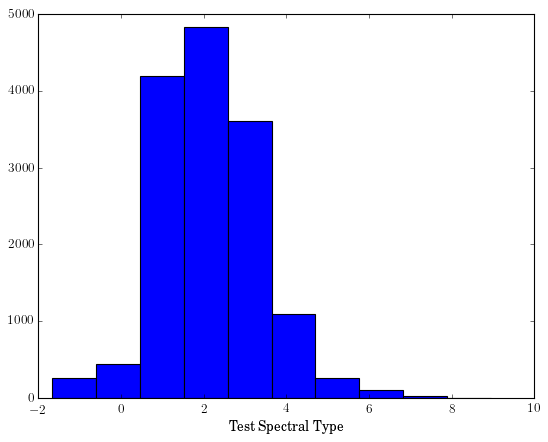

In [18]:
plt.hist(tst_label.T[0])
plt.xlabel('Test Spectral Type')
plt.show()

In [26]:
len(np.where(tst_label.T[0] > 7)[0])

21